# Задача классификации изображений


Стоит задача написать нейросеть для классификации изображений на  классов: Television, Sofas, Jeans, T-shirt и Other.

Для этого вначале подключим все необходимые библиотеки. Так же для удобства будем работать в текущей директории и скроем сообщения о предупреждениях:

In [49]:
## -*- coding: utf-8 -*-

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
from torchvision import datasets, transforms, models
from torchvision.transforms import v2
import os
import matplotlib.image as mpimg
import torch.nn as nn
import torch.nn.functional as F
import csv
import warnings 
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
from skimage import io

os.chdir(os.getcwd())
warnings.filterwarnings('ignore')

Объявим класс для инициализации нашего датасета, основываясь на структуре используемых csv файлов

In [50]:
class ImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 1])
        image = io.imread(img_path)
        label = self.img_labels.iloc[idx, 0]
        if self.transform:
            image = self.transform(image)
        return image, label

Для корректоной работы нейросети, изображения должны быть в одном формате, соответственно приведем все изображения к размеру 150x150 и переведем их в тензоры. 
С вышеуказанными изменениями получем два датасета. Первый - с 4мя классами Television, Sofas, Jeans, T-shirt и второй, включающий в себя изображения для класса other.

In [51]:
transform1 = transforms.Compose([         
            v2.ToTensor(),
            v2.Resize([150, 150])])

train_data = ImageDataset(annotations_file = 'table.csv', img_dir = 'test_data', transform=transform1)
train_dataD = ImageDataset(annotations_file = 'other3.csv', img_dir = 'test_data', transform=transform1)

Поделим оба датасета на обучающий, валидационный и тестовый:

In [52]:
train_size = int(len(train_data) * 0.80)
val_size = len(train_data) - train_size
train_data1, val_data1 = torch.utils.data.random_split(train_data, [train_size, val_size])
train_data2, val_data2 = torch.utils.data.random_split(train_data, [train_size, val_size])
train_data3, val_data3 = torch.utils.data.random_split(train_data, [train_size, val_size])
train_loader = [torch.utils.data.DataLoader(train_data1, batch_size=20, shuffle=True), torch.utils.data.DataLoader(train_data2, batch_size=20, shuffle=True), torch.utils.data.DataLoader(train_data3, batch_size=20, shuffle=True)]
val_loder = [torch.utils.data.DataLoader(val_data1, batch_size=20, shuffle=True), torch.utils.data.DataLoader(val_data2, batch_size=20, shuffle=True), torch.utils.data.DataLoader(val_data3, batch_size=20, shuffle=True)]

train_sizeD = int(len(train_dataD) * 0.70)
val_sizeD = int(len(train_dataD) * 0.20)
test_sizeD = len(train_dataD) - train_sizeD - val_sizeD
train_data1D, val_data1D, test_data1D = torch.utils.data.random_split(train_dataD, [train_sizeD, val_sizeD, test_sizeD])
train_data2D, val_data2D, test_data2D = torch.utils.data.random_split(train_dataD, [train_sizeD, val_sizeD, test_sizeD])
train_data3D, val_data3D, test_data3D = torch.utils.data.random_split(train_dataD, [train_sizeD, val_sizeD, test_sizeD])
train_loaderD = [torch.utils.data.DataLoader(train_data1D, batch_size=20, shuffle=True), torch.utils.data.DataLoader(train_data2D, batch_size=20, shuffle=True), torch.utils.data.DataLoader(train_data3D, batch_size=20, shuffle=True)]
val_loderD = [torch.utils.data.DataLoader(val_data1D, batch_size=20, shuffle=True), torch.utils.data.DataLoader(val_data2D, batch_size=20, shuffle=True), torch.utils.data.DataLoader(val_data3D, batch_size=20, shuffle=True)]
test_loaderD = [torch.utils.data.DataLoader(test_data1D, batch_size=20, shuffle=True), torch.utils.data.DataLoader(test_data2D, batch_size=20, shuffle=True), torch.utils.data.DataLoader(test_data3D, batch_size=20, shuffle=True)]


Объявим нашу модель:

In [70]:
class ConvNet(nn.Module, ):
    def __init__(self, exits_num):
        super().__init__()
        #150*150*3
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=(3,3))
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2))
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=9, kernel_size=(3,3)) 
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2))
        self.conv3 = nn.Conv2d(in_channels=9, out_channels=12, kernel_size=(3,3))
        self.pool3 = nn.MaxPool2d(kernel_size=(2,2))
        self.flatten = nn.Flatten()
        self.drop = nn.Dropout(0.5)
        self.fc1 = nn.Linear(12*17*17, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, exits_num)

    
    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        x = self.flatten(x)
        x = self.drop(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim = 1)
        return x

Объявим функцию для оценки:

In [54]:
def evaluate(model, dataloader, loss_fn):
    
    losses = []

    num_correct = 0
    num_elements = 0

    for i, batch in enumerate(dataloader):
        
        X_batch, y_batch = batch
        num_elements += y_batch.size(0)
        with torch.no_grad():
            logits = model(X_batch.to(device))
            loss = loss_fn(logits, y_batch.to(device))
            losses.append(loss.item())
            
            y_pred = torch.argmax(logits, dim=1).cpu()
            
            num_correct += torch.sum(y_pred == y_batch)
    accuracy = num_correct / num_elements
            
    return accuracy, np.mean(losses)

Объявим функцию для обучения нашей сети. Вней реализован механизм отслеживания точности и потерь на валидационной выборке. При этом сохраняется модель с наименьшим значением потерь на валидации, что позваляет избежать переобучения:

In [55]:
def train(model, loss_fn, optimizer, n_epoch, load, val):
    global m, number, minloss
    num_iter = 0
    for epoch in range(n_epoch):

        model.train(True)

        running_losses = []
        running_accuracies = []
        for i, batch in enumerate(load):
            X_batch, y_batch = batch
            logits = model(X_batch.to(device))
            
            loss = loss_fn(logits, y_batch.to(device))
            running_losses.append(loss.item())

            loss.backward()
            optimizer.step() 
            optimizer.zero_grad() 
            model_answers = torch.argmax(logits, dim=1)
            train_accuracy = torch.sum(y_batch == model_answers.cpu()) / len(y_batch)
            running_accuracies.append(train_accuracy)
            num_iter += 1

        val_accuracy, val_loss = evaluate(model, val, loss_fn=loss_fn)
            
        model.train(False)
        accuracy = (sum(running_accuracies) * 100 / len(running_accuracies)).numpy()
        losst = sum(running_losses) * 100 / len(running_losses)
        print("Epoch:", str(epoch+1) + ', model', number)
        print("Train | accuracy:", accuracy, ", loss:", losst)
        print("Validation | accuracy:", val_accuracy.numpy() * 100, ", loss:", val_loss * 100)
        m[number][0] += [accuracy]
        m[number][1] += [losst]
        m[number][2] += [val_accuracy.numpy() * 100]
        m[number][3] += [val_loss * 100]
        print("__________________________________________________________")
        if val_loss <= minloss:
            torch.save(model.state_dict(), './model.pt')
            minloss = val_loss
        
    return model

Следующая функция служит для реализации дообучения нашей сети. Последний слой заменяется, а некоторое количество предыдущих слоев замораживаются, что позволяет сохранить веса, полученные при первичном обучении:

In [88]:
import torch.nn as nn

def create_model(model, num_freeze_layers, num_out_classes):
    model.fc3 = nn.Linear(512, 5)
    for i, layer in enumerate(model.children()):
        if i < num_freeze_layers:
            for param in layer.parameters():
                param.requires_grad = False

    return model

Создадим модель, перенесем вычисления на gpu и будем теренровать её 10 эпох (такое значение избыточно, но в обучении есть защита от переобучения)

In [57]:
minloss = 200
m = [[[], [], [], []], [[], [], [], []], [[], [], [], []]]
for number in range (0, 3):
    print("Model " + str(number) + ":")
    model = ConvNet()
    loss_fn = torch.nn.CrossEntropyLoss()
    learning_rate = 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model = train(model, loss_fn, optimizer, 20, train_loader[number], val_loder[number])

Model 0:


Epoch: 1, model 0
Train | accuracy: 54.516132 , loss: 105.19985546988826
Validation | accuracy: 84.10596251487732 , loss: 53.00981290638447
__________________________________________________________
Epoch: 2, model 0
Train | accuracy: 86.7742 , loss: 37.77037914241514
Validation | accuracy: 89.40397500991821 , loss: 47.37341534346342
__________________________________________________________
Epoch: 3, model 0
Train | accuracy: 90.32258 , loss: 27.313509775746255
Validation | accuracy: 88.7417197227478 , loss: 44.1417058929801
__________________________________________________________
Epoch: 4, model 0
Train | accuracy: 94.03227 , loss: 19.519959330078095
Validation | accuracy: 93.37748289108276 , loss: 28.959895251318812
__________________________________________________________
Epoch: 5, model 0
Train | accuracy: 94.67743 , loss: 14.854026669936795
Validation | accuracy: 93.37748289108276 , loss: 34.632202284410596
__________________________________________________________
Epoch: 6, m

Посмотрим на график точности и потерь для тестовой и валидационной выборок. 

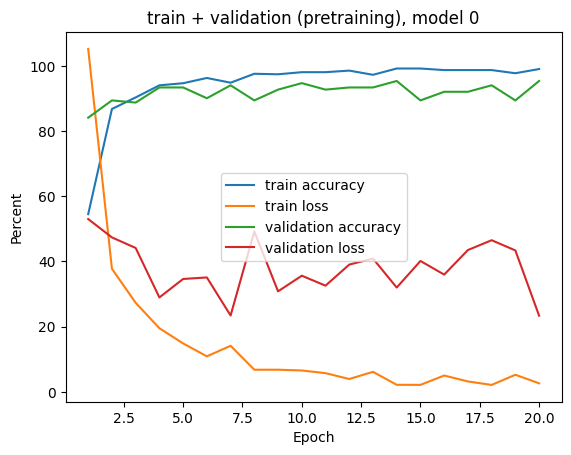

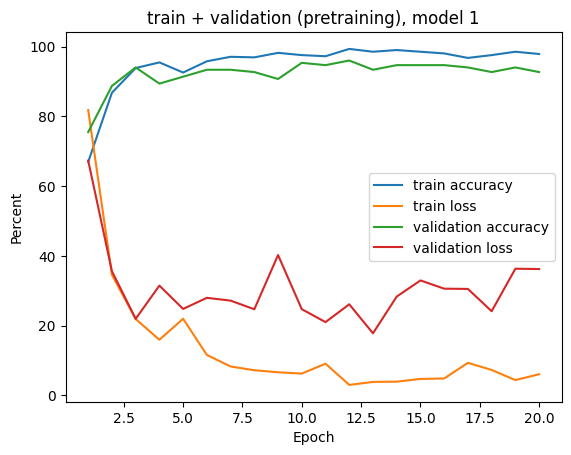

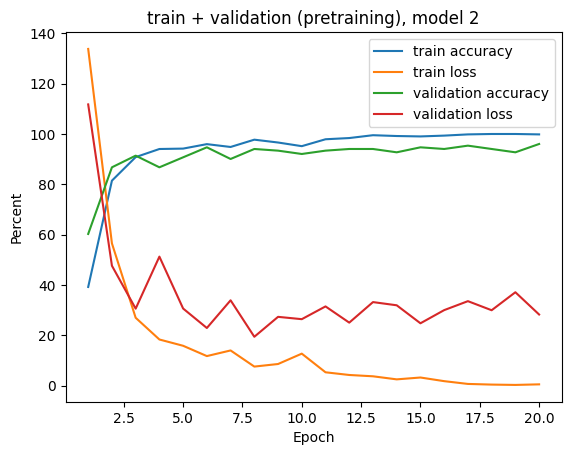

In [58]:
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
for i in range (0, 3):
    plt.plot(x, m[i][0], label='train accuracy')
    plt.plot(x, m[i][1], label='train loss')
    plt.plot(x, m[i][2], label='validation accuracy')
    plt.plot(x, m[i][3], label='validation loss')
    plt.title('train + validation (pretraining), model ' + str(i))
    plt.xlabel('Epoch')
    plt.ylabel('Percent')
    plt.legend()

    plt.show()

Заметим, что после определенной эпохи значение потери на валидации начинает расти, что значит, что модель перееобучилась, поэтому необходимо ее вовремя сохранить.


Заморозим все слои кроме последнего, заменив его на слой с 5ью выходами. Дообучим модель на датасете с 5ью классами:

In [96]:
m = [[[], [], [], []], [[], [], [], []], [[], [], [], []]]
minloss = 120
model.load_state_dict(torch.load('model.pt'))
model = create_model(model, 3, 5)
train_accuracy = []
test_accuracy = []

torch.save(model.state_dict(), './test.pt')

for number in range (0, 3):
    model.load_state_dict(torch.load('test.pt'))
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    model = train(model, loss_fn, optimizer, 20, train_loaderD[number], val_loderD[number])
    trainT, _ = evaluate(model, train_loaderD[number], loss_fn)
    testT, _ = evaluate(model, test_loaderD[number], loss_fn)
    train_accuracy += [trainT]
    test_accuracy += [testT]

Epoch: 1, model 0
Train | accuracy: 94.25 , loss: 23.44952941472002
Validation | accuracy: 88.59649300575256 , loss: 59.622182324528694
__________________________________________________________
Epoch: 2, model 0
Train | accuracy: 100.0 , loss: 0.36049837378527627
Validation | accuracy: 87.71929740905762 , loss: 78.34131607378367
__________________________________________________________
Epoch: 3, model 0
Train | accuracy: 100.0 , loss: 0.1909364912626188
Validation | accuracy: 85.52631735801697 , loss: 72.27706406265497
__________________________________________________________
Epoch: 4, model 0
Train | accuracy: 99.75001 , loss: 0.6217710289584488
Validation | accuracy: 85.52631735801697 , loss: 115.3620923558871
__________________________________________________________
Epoch: 5, model 0
Train | accuracy: 99.12501 , loss: 2.465617929256041
Validation | accuracy: 84.21052694320679 , loss: 97.80283396442732
__________________________________________________________
Epoch: 6, model 0
T

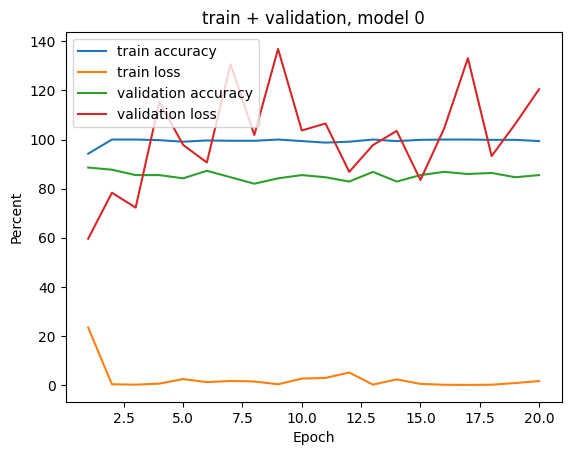

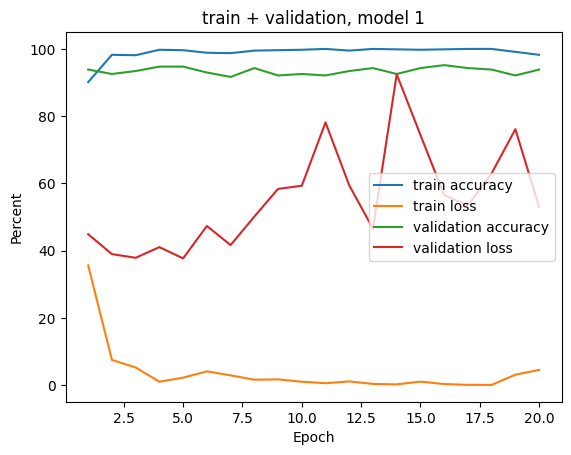

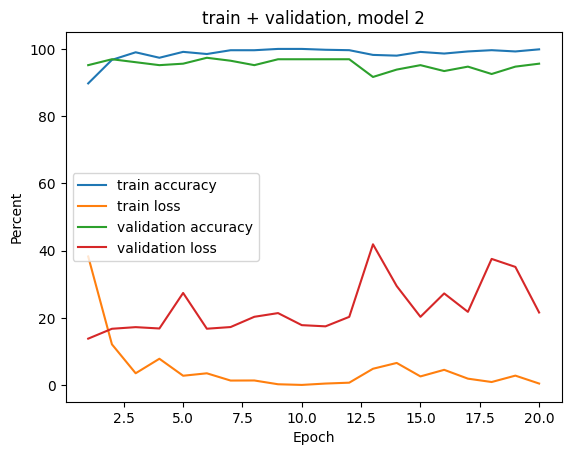

In [97]:
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
for i in range (0, 3):
    plt.plot(x, m[i][0], label='train accuracy')
    plt.plot(x, m[i][1], label='train loss')
    plt.plot(x, m[i][2], label='validation accuracy')
    plt.plot(x, m[i][3], label='validation loss')
    plt.title('train + validation, model ' + str(i))
    plt.xlabel('Epoch')
    plt.ylabel('Percent')
    plt.legend()

    # Отображаем график
    plt.show()

Заметим, что у потерь валидации очень сильно разнятся значения от эпохи к эпохе, поэтому важно сохранять модель с наилучшими данными      

Посморим итоговые результаты на обучающем и тестовом датасетах:

In [98]:
for i in range(0, 3):
    print("Model " + str(i) + ":")
    print('Train accuracy:', train_accuracy[i].numpy())
    print('Test accuracy:', test_accuracy[i].numpy())
    print("__________________________________________________________")

Model 0:
Train accuracy: 1.0
Test accuracy: 0.8596491
__________________________________________________________
Model 1:
Train accuracy: 1.0
Test accuracy: 0.9122807
__________________________________________________________
Model 2:
Train accuracy: 1.0
Test accuracy: 0.9736842
__________________________________________________________
